# Exercise 5: the formation of molecular oxygen using molecular orbital theory

This exercise examines the formation of **triplet oxygen**, the most stable and most common allotropic form of O$_2$. Triplet oxygen has two electrons in its two **degenerate** (i.e., having the same energy, or, more formally, two distinct microstates corresponding to the same macrostate) $\pi^*$ orbitals. There are four independent spin states arising from these two spin-1/2 electrons, and so there are a total of $\binom{4}{2}=6$ possible ways (microstates) to arrange the two electrons into the two degenerate $\pi^*$ orbitals. Here, we will only consider the triply-degenerate ground state: according to **Hund's rules**, the configuration with two unpaired electrons in two $\pi^*$ orbitals is energetically favoured.

In the following, you will generate a [molecular orbital schema](https://en.wikipedia.org/wiki/Triplet_oxygen#/media/File:Valence_orbitals_of_oxygen_atom_and_dioxygen_molecule_(diagram).svg) for triplet oxygen, that is, the configuration for which the total spin equals 1.

## 1. Introduction

Log into your account on `JupyterHub` in a similar manner as described in previous exercises, and `pull` the newest exercise files from the GitHub repository:
```bash
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
    $ cd exercise-6_files
```
## 2. The triplet molecule
### 2.1 The input file: a closer look

Move into the directory for the triplet molecule and open the input file. There is some new syntax in the input file, including use of the `@`, `$`, and `{}`characters. We will go through them briefly here as well as live in the exercise:

* `@`: in the combination `@SET`, this command at the beginning of an input file allows us to define variables which we will reference later in the input file
* `$`: syntax inherited from Unix: used to indicate that a variable will be referred to; requires curly braces `{}` afterwards
* `{}`: encloses the name of a variable to be referred to

This syntax is best illustrated by perusing the input file. Furthermore, the lines 

```
&E_DENSITY_CUBE
&END E_DENSITY_CUBE
NLUMO 1
NHOMO 1
```
in the `&PRINT` subsection in `&DFT` will generate the files that we will use for this exercise.

The submit script (almost identical to that of exercise 3) is:

```
#!/bin/bash

#SBATCH -N 1
#SBATCH -n 1
#SBATCH --time=4:00:00
#SBATCH --job-name="nice name"
#SBATCH --mem-per-cpu=1024
#SBATCH --output=stdout.txt
#SBATCH --error=stderr.txt

# module load openmpi/4.0.2
# module load gcc/6.3.0 openmpi/4.0.2 cp2k/8.2
INP=triplet.inp
OUT=triplet.out
/cluster/scratch/danielep/cp2k.ssmp -i triplet.inp > triplet.out
```

Make sure the input file and submit script are in the same directory and submit the geometry optimization; it shouldn't take so long to run. Import some necessary packages and libraries by executing the following cell:

In [34]:
from ase.visualize import view
from ase.io import read
import nglview as nv

### 2.2: visualization of the electronic density

Once the job has concluded, open one of the `.cube` output files. These types of files are used by CP2K and many other electronic structure programs to store spin, orbital, or electronic density values on a three-dimensional grid. Some good documentation can be found [here](https://h5cube-spec.readthedocs.io/en/latest/cubeformat.html) and [here](https://manual.q-chem.com/5.3/sec_cubefiles.html).

**Due to a bug, it is imperative that you copy your `.cube` files to your `/tmp/` directory and access them from there, as in the example, and NOT use them directly in the output directory:**

In [35]:
!cp /cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol/o2-ELECTRON_DENSITY-1_0.cube /tmp

In [36]:
file = '/tmp/o2-ELECTRON_DENSITY-1_0.cube'
atoms = read(file)

view = nv.NGLWidget()
view.add_component(nv.ASEStructure(atoms))

c_2 = view.add_component(file)
c_2.clear()
c_2.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

c_3=view.add_component(file)
c_3.clear()
c_3.add_surface(color='green', isolevelType="value", isolevel=0.015, opacity=0.15)

view

NGLWidget()

**!! Note: in this case as in the rest of the exercise, you might need to play around a bit with the values of the `isolevel` parameter. In general, both values should be quite small (ie absolute values close to zero), with one being negative and one being positive. !!**

### 2.3: Computing density differences

This however is just the electronic density of the oxygen molecule: what is probably more interesting, are density *differences*. In order to compute these differences, we use a tool called [cubecruncher](https://github.com/cp2k/cp2k/tree/master/tools/cubecruncher), which allows us to perform various operations on cube files -- notably subtraction.

Our goal is to obtain the density difference, and as such, we must subtract off the electron densities of each of the individual (!) oxygen atoms. To do this, we run two more simulations (ie, one for each of the individual atoms), whereby each simulation will generate the electron density (in turn, contained in its respective cube file) of that respective oxygen atom.

1. We proceed by making a new directory within the current one: `$ mkdir diffs`
2. Move into the `diffs` directory and copy the full electron density from the foregoing calculation into the `diffs` directory; give it a more suitable name if it helps:
```bash
$ cd diffs
$ cp ../o2_trip-ELECTRON_DENSITY-1_0.cube ./full.cube
```
3. We now need to run the same simulation as for the molecule, except now for each of the individual two oxygen atoms. Let's make two new directories to contain these new simulations, and we copy the input file and run script from the parent calculation into these new directories:

```bash
$ mkdir o1
$ mkdir o2
$ cp ../{triplet.inp,submit.sh} o1
$ cp ../{triplet.inp,submit.sh} o2
```

4. Move into the `o1` directory and remove the atom labeled `O2`:

```
    &COORD [angstrom]
  O1         6.2069331992        6.2068856913        5.6293948156
  O2         6.2068666902        6.2069143409        6.7844056115 #REMOVE
    &END COORD
```

and its associated `&KIND` a few lines later:

```
    &KIND O2 #REMOVE ALL THIS
       MAGNETIZATION 0
       ELEMENT O
       BASIS_SET aug-cc-pVTZ
       POTENTIAL ALL
   &END KIND
```

5. For bookkeeping's sake, change the name of the project:
```
PROJECT o1
```
and save and quit the file.

6. For bookkeeping's sake, it might not be a bad idea to change the name of the input file itself. Don't forget to adjust anything in the submit script accordingly. Once everything is good, submit the job.

7. Repeat steps 4-6 for o2.

8. Copy (or move) the electron density files from each of the individual atoms into the `diff` directory (your relative paths might be a bit different depending on which directory exactly you're currently in):
```bash
$ cp o1/o1-ELECTRON_DENSITY-1_0.cube ./o1.cube
$ cp o2/o2-ELECTRON_DENSITY-1_0.cube ./o2.cube
```

9. Now we have the three files --- `full.cube, o1.cube, o2.cube` --- which we'll need to plot the density differences. Let's first take `full.cube` minus `o1.cube` and save this temporary difference to a file `temp.diff`:
```bash
$ /cluster/scratch/danielep/cubecruncher.x -i full.cube -o temp.cube -subtract o1.cube
```

10. Now we subtract `o2.cube` from `temp.cube` and store the desired difference file to `diff.cube`:
```bash
$ /cluster/scratch/danielep/cubecruncher.x -i temp.cube -o diff.cube -subtract o2.cube
```

### Assignment 1: Visualizing the electronic density difference

Use the code of a few cells above (modify as necessary) to visualize the `diff.cube` file. Comment on how it differences from the first plot.

In [37]:
# !cp /cluster/home/lenag/daint_oxygen/triplet_mol/diff/diff.cube /tmp
!cp ./triplet_mol/diffs/diff.cube /tmp

cp: cannot stat './triplet_mol/diffs/diff.cube': No such file or directory


In [38]:
file2 = '/tmp/diff.cube'
atoms2 = read(file2)

view2 = nv.NGLWidget()
view2.add_component(nv.ASEStructure(atoms2))

c_4 = view.add_component(file2)
c_4.clear()
c_4.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

c_5=view.add_component(file2)
c_5.clear()
c_5.add_surface(color='green', isolevelType="value", isolevel=0.015, opacity=0.15)

view2
#as of now structure view did not work, only the red molecule is visible

NGLWidget()

**!! NOTE: Your result might not be "displaying as expected" (like it was with me). To remedy this, restart your kernel (Kernel -> Shut Down All Kernels) and restart your server. !!**

### End Assignment 1

### Assignment 2: Visualizing the molecular orbitals

You will have certainly noticed the plethora of `WFN_000xyz_a-b_c.cube` files generated as a result of the calculation. These are the HOMO-$\eta$ and LUMO+$\xi$ orbitals, where the values of $\eta$ and $\xi$ were specified in the `.inp` file, respectively. 

1. The first subtask of this assignment will simply involve decoding the names of these files, and assigning them to the respective molecular orbital (HOMO-3, LUMO+2, etc.) to which they belong. Open one of these `WFN_000xyz_a-b_c.cube` files and observe how the first two lines (which are indeed always **comment** lines in `.cube` files) look like (for the `o2-WFN_00001_1-1_0.cube` file):

```
-Quickstep-
  WAVEFUNCTION            1  spin            1  i.e. HOMO -           -8
```

Write a script, either in Python or in Bash, that takes the "informational part" of the file name,  extracts the data of the second comment line, and writes this information to a `.txt` file. The script should loop through all the `WFN` files in the current directory. This `.txt` file will be your reference for the remainder of this exercise. If you do it in Python, you might need the `sys` and/or `os` libraries; if you do it in Bash, you'll surely need `grep`. In any case, completion of this subtask will involve some string manipulation. The `.txt` file might look like something similar to this:

```
file wavefunction spin orbital
00001_1-1_0 1 1 HOMO-8
...
```

Of course, it doesn't *have* to look like *exactly* like this, but a format similar to the above might be helpful.

2. Now that we've got a correspondence between these "cryptic" `WFN.cube` files and the orbitals they contain, we can plot them. Using the `.txt` file you generated in subtask 1 as a reference (so that you know exactly what files to plot), plot all of the occupied orbitals and the first 3 or 4 unoccupied orbitals. 

In [39]:
## 1
# script for decoding the wavefunction files and store important information in txt file
# plan: loop through all WFN files, extract second comment line, write information in txt file
# with adjusted spacing / naming etc. 

#import libraries and set environment
import os
import sys
#directory = 'triplet_mol'
search_str = "o2-WFN"
#change directory, so files can be read
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol')

#prepare txt file
o = open("overview.txt", "w")
o.write("file wavefunction spin orbital\n")

files_wfn = []
for file in os.listdir():
    if file.startswith(search_str):
        #print(file)
        files_wfn.append(file)

#print(files_wfn)
#loop over all files stored in the list from before
for filename in files_wfn:
    #print(filename)
    with open(filename.strip()) as f2:
        lines = f2.readlines()
        
        second_line = lines[1] # Extract the whole second line
        
        #remove /n (I don't know why this appears if this step is not taken)
        second_line = second_line[0:-1]

        contents = second_line.split(" ") #split the line into parts
        
        information = [] #storage for "important" information
        for i in range (0,len(contents)):
            if contents[i] == "" or contents[i] == "WAVEFUNCTION" or contents[i] == "i.e." or contents[i] == "-" or contents[i] == "spin":
                pass
            else:
                information.append(contents[i]) #store everything expect the empty characters
                #information is stored like this: wfct value, spin value, HOMO/LUMO, value 
                
        filename_short = filename[7:16]
        wfct = str(information[0])
        spin = str(information[1])
        orbital = information[2:] #still a list
        orbital = str(''.join(orbital))
        
        #write into new txt file (overview)
        o.write(filename_short + " " + wfct + " " + spin + " " + orbital + "\n")      


In [41]:
## 2
#
#import libraries and set environment
import os
import sys
import shutil
search_str = "o2-WFN"
#change directory, so files can be read
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol')

files_wfn = []
source_folder = '/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol/'
destination_folder = '/tmp/'
for file in os.listdir():
    if file.startswith(search_str):
        files_wfn.append(file)

        # construct full file path
        source = source_folder + file
        destination = destination_folder + file
        
        #copy files into destination folder
        shutil.copy(source, destination)
        #print('copied', file)

#loop over all files stored in the list from before
os.chdir('/tmp/') #for visualization work in the tmp directory

for filename in files_wfn:
    print(filename)
    atoms = read(filename)

    view = nv.NGLWidget()
    view.add_component(nv.ASEStructure(atoms))

    c_4 = view.add_component(filename)
    c_4.clear()
    c_4.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

    c_5=view.add_component(filename)
    c_5.clear()
    c_5.add_surface(color='green', isolevelType="value", isolevel=0.015, opacity=0.15)
    
    view
    
#Comment: I think the code works so far, that all the wanted files are read, 
#but the visualization does not appear...

o2-WFN_00001_1-1_0.cube
o2-WFN_00002_1-1_0.cube
o2-WFN_00003_1-1_0.cube
o2-WFN_00004_1-1_0.cube
o2-WFN_00005_1-1_0.cube
o2-WFN_00006_1-1_0.cube
o2-WFN_00007_1-1_0.cube
o2-WFN_00008_1-1_0.cube
o2-WFN_00009_1-1_0.cube
o2-WFN_00001_2-1_0.cube
o2-WFN_00002_2-1_0.cube
o2-WFN_00003_2-1_0.cube
o2-WFN_00004_2-1_0.cube
o2-WFN_00005_2-1_0.cube
o2-WFN_00006_2-1_0.cube
o2-WFN_00007_2-1_0.cube
o2-WFN_00010_1-1_0.cube
o2-WFN_00011_1-1_0.cube
o2-WFN_00012_1-1_0.cube
o2-WFN_00008_2-1_0.cube
o2-WFN_00009_2-1_0.cube
o2-WFN_00010_2-1_0.cube


In [7]:
## 2 (Try 2)
# for loop, plotting all, same code as above

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv

search_str = "o2-WFN"
#change directory, so files can be read
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol')

# Define the molecule
mol = gto.M(
    atom='''
    O 0.000000  0.000000  0.000000
    O 0.000000  0.000000  1.218296
    ''',
    basis='sto3g'
)

# Run the SCF calculation
mf = scf.RHF(mol).run()

files_wfn = []
for file in os.listdir():
    if file.startswith(search_str):
        #print(file)
        files_wfn.append(file)

#print(files_wfn)
#loop over all files stored in the list from before
for filename in files_wfn:
    print(filename)
    data = np.loadtxt(filename, skiprows=2)
    
    # Get the grid dimensions and spacing
    nx, ny, nz = data[0:3].astype(int)
    origin = data[3:6]
    spacing = data[6:9]

    # Reshape the data into a 3D array
    rho = data[9:].reshape((nx, ny, nz))

    # Define the grid
    x = np.linspace(origin[0], origin[0] + (nx-1)*spacing[0], nx)
    y = np.linspace(origin[1], origin[1] + (ny-1)*spacing[1], ny)
    z = np.linspace(origin[2], origin[2] + (nz-1)*spacing[2], nz)
    grid = pv.UniformGrid()
    grid.dimensions = rho.shape
    grid.origin = origin
    grid.spacing = spacing
    grid.point_arrays["Density"] = rho.flatten(order="F")  # Fortran order

    # Create the plotter
    p = pv.Plotter()

    # Add the grid to the plotter
    p.add_mesh(grid, cmap="coolwarm")

    # Set the camera position
    p.camera_position = [
    (x.max() - x.min()) * 2,
    (y.max() - y.min()) * 2,
    (z.max() - z.min()) * 2,
    np.mean([x.max(), x.min()]),
    np.mean([y.max(), y.min()]),
    np.mean([z.max(), z.min()]),
    0,
    1,
    0
        ]

    # Show the plot
    p.show()

ModuleNotFoundError: No module named 'pyvista'

In [22]:
## 2 (Try 3)
# for loop, plotting all, same code as above

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyscf import gto, scf, cube

search_str = "o2-WFN"
#change directory, so files can be read
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6/triplet_mol')

# Define the molecule
mol = gto.M(
    atom='''
    O 0.000000  0.000000  0.000000
    O 0.000000  0.000000  1.218296
    ''',
    basis='sto3g'
)

# Run the SCF calculation
mf = scf.RHF(mol).run()

files_wfn = []
for file in os.listdir():
    if file.startswith(search_str):
        #print(file)
        files_wfn.append(file)

#print(files_wfn)
#loop over all files stored in the list from before
for filename in files_wfn:
    print(filename)
    rho = cube.load_cube("density.cube", mol)
    
    x, y, z = rho.coords

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=rho, s=0.1)
    plt.show()

ImportError: libhdf5.so.101: cannot open shared object file: No such file or directory

In [42]:
# move electron density file into tmp folder
import os
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6')
print("Current Directory: ", os.getcwd())

!cp ./triplet_atom/o-ELECTRON_DENSITY-1_0.cube /tmp

Current Directory:  /cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6


In [43]:
# code to visualize electron density (same as above), worked
file2 = '/tmp/o-ELECTRON_DENSITY-1_0.cube'
atoms2 = read(file2)

view2 = nv.NGLWidget()
view2.add_component(nv.ASEStructure(atoms2))

c_4 = view2.add_component(file2)
c_4.clear()
c_4.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

c_5=view2.add_component(file2)
c_5.clear()
c_5.add_surface(color='green', isolevelType="value", isolevel=0.005, opacity=0.15)


view2

NGLWidget()

### End Assignment 3

## 3. ~~Reading~~ Interpreting the output files.

Before concluding today's exercise, there are two pieces of information that we should be made aware of, which can be found towards the end of the respective `.out` files. Open the `triplet.out` file for the molecule and scroll towards the bottom until you find

```
  Eigenvalues of the occupied subspace spin            1
 ---------------------------------------------
     -18.91106343     -18.91098286      -1.20199960      -0.75825075
      -0.49784172      -0.49451467      -0.49451467      -0.25446183
      -0.25446183
 Fermi Energy [eV] :   -6.924259
  
  Eigenvalues of the occupied subspace spin            2
 ---------------------------------------------
     -18.88507991     -18.88499208      -1.15811454      -0.69227713
      -0.46456304      -0.42601125      -0.42601125
 Fermi Energy [eV] :  -11.592356
```

Even though we didn't plot and visualize the spin densities explicitly, we should note that we have indeed calculated them (see the output files). The table of `Eigenvalues of the occupied subspace spin` shows exactly the spin-splitting phenomenon that we expect from the molecular orbital schema of oxygen; the `1` resp. `2` indicates the spin up and spin down. (DONE) 

### Assignment 4: extraction of the energies and construction of the MO schema

Use the values of the energy from the output files of the calculations from both the triplet molecule and the triplet atom to generate an ordering of the energies. Similar to [this figure](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Physical_Chemistry_(LibreTexts)/09%3A_Chemical_Bonding_in_Diatomic_Molecules/9.10%3A_Molecular_Orbital_Theory_Predicts_that_Molecular_Oxygen_is_Paramagnetic), energy should be on the vertical axis. Your plot can be as sophisticated or as simple as you like, but should contain all of the following information:
* show the degeneracy in energy between distinct states (ie, that the two 2s states have the same energy and the two 2p states have the same energy, although the latter corresponds to a different (microstate!) spin configuration);
* use the lecture slides (particularly the slide 'molecular orbitals for simple diatomic molecules') to show and label the molecular orbital splitting between the $s$ resp. $p$ orbitals;
* show the respective spin configuration of each shell (up resp. down);
* contain all necessary labels (see the snippet above)
* use what was learned in class to explain why molecular oxygen is paramagnetic



Text(0.5, 1.0, 'Energy levels for the O2 molecule')

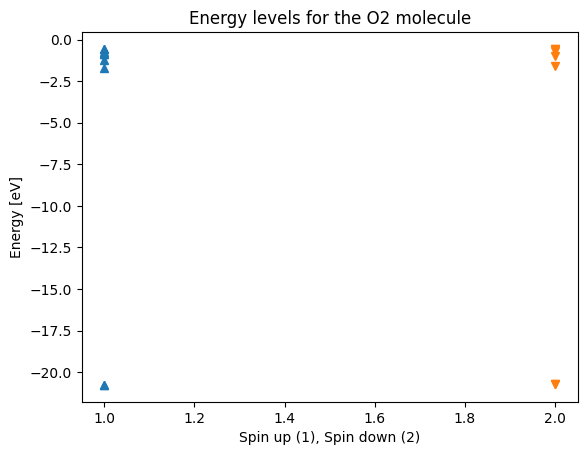

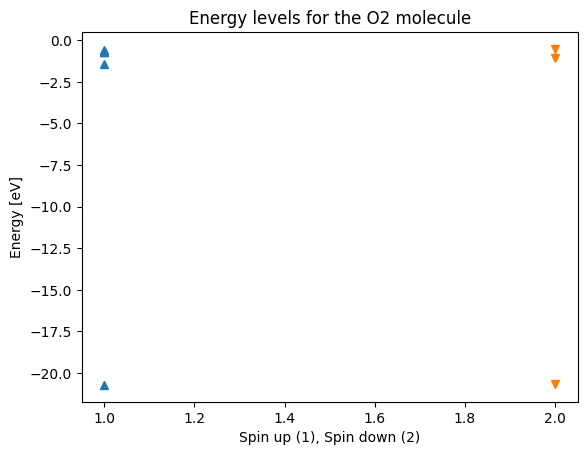

In [103]:
os.chdir('/cluster/home/lenag/Molecular-and-Materials-Modelling-FS2023/exercise6')
import matplotlib.pyplot as plt

#in the file "energies_assignment4.txt" the values are stored in the following way
#spin (1 or 2), energy, Molecule/Atom (mol or atom)
file = './energies_assignment4.txt'

#now 2 plots are made, one for the molecule and one for the atom
with open(file, "r") as f:
    lines = f.readlines()
    #print(lines)
    mol = []
    atom = []
    for i in range(1, len(lines)):
        line = lines[i]
        line = line[0:-1]
        if line.find("mol") > -1:
            mol.append(line)
        else:
            atom.append(line)
                                              
#print("MOLECULE", mol)
#print("ATOM", atom)

#for the molecule

# Create an empty matrix to store the data
MOLECULE = []

# Loop through each string in the list
for str in mol:
    # Split the string into columns based on the space character
    columns = str.split()
    # Append the columns to the matrix
    MOLECULE.append(columns)
    
#plot 1
energies = [float((row[1])) for row in MOLECULE]
spins = [float((row[0])) for row in MOLECULE]
plt.plot(spins[0:9], energies [0:9], '^')
plt.plot(spins[9:], energies [9:], 'v')

plt.xlabel('Spin up (1), Spin down (2)')
plt.ylabel('Energy [eV]')
plt.title('Energy levels for the O2 molecule')

#for the atom
# Create an empty matrix to store the data
ATOM = []

# Loop through each string in the list
for str in atom:
    # Split the string into columns based on the space character
    columns = str.split()
    # Append the columns to the matrix
    ATOM.append(columns)

#plot 2
plt.figure()
energies = [float((row[1])) for row in ATOM]
spins = [float((row[0])) for row in ATOM]
plt.plot(spins[0:5], energies [0:5], '^')
plt.plot(spins[5:], energies [5:], 'v')

plt.xlabel('Spin up (1), Spin down (2)')
plt.ylabel('Energy [eV]')
plt.title('Energy levels for the O2 molecule')


### End Assignment 4